# CV Lab project - Method#1: Frame Differencing


In [20]:
import pandas as pd
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
import re
from skimage import exposure
import imageio
import copy
from skimage.filters import unsharp_mask, gaussian, difference_of_gaussians

## Load The Images


Summary of Pipeline:
1. compute GLOBAL_MEAN_BG from all training imgs
2. optionally gaussian_mean it
3. for each img, substract global mean from it
4. img = redchannel - channel_wise_mean
5. get local mean frame from 7 frames of img
6. img - localMean
7. sum the images and apply gaussian blurring
8. thresholding >0.75 of max
9. graw bb

In [13]:
merg_patterns = [ 'merg_avg_masked.png', 'merg_v1_masked.png',  'merg_v2_masked.png' ] #available list of merge methods
dirs = ['train','validation']
fns = ['train','valid']
mask = cv2.imread('data/mask.png',0)
chosenMergeMethod = merg_patterns[0] #0 has the best contrast


## 0. Utility Functions

In [18]:
def get_images (fn_pattern, folder='./data/validation/valid-1-0/', time_frames = 7):
    img_ = []
    fidx = []
    for fn in os.listdir(folder):
        if (fn_pattern in fn):
            fidx += [int(fn[0])]
            img_ += [cv2.imread(folder+fn)/255.0]
    
    #rearrange img according to filename
    img = copy.deepcopy(img_)
    for i, idx in enumerate(fidx):
        img[idx] = img_[i]

    return img


def get_global_background (fn_pattern='', time_frames = 7):
    train_folder_pattern = re.compile('train-(.*)-(.*)')
    background = []
    for filename in os.listdir('./data/train'):
        if train_folder_pattern.match(filename) is not None:
            for tf in range(time_frames):
                fn = os.path.join('./data/train/'+filename,str(tf)+'-'+fn_pattern)
                #print(' ',fn,end='') #verbose
                im = cv2.imread(fn)
                im = cv2.bitwise_and(im,im,mask=mask)
                background += [im/255.0]

    m = np.mean(background, axis=0)

    return m

## 1. Compute Global Mean Background

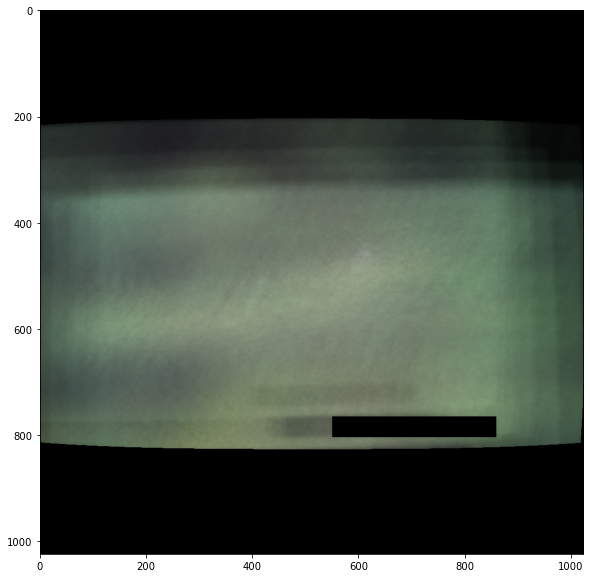

In [25]:
global_mean_bg = get_global_background(chosenMergeMethod)
global_mean_bg = cv2.bitwise_and(global_mean_bg,global_mean_bg,mask=mask)
plt.figure(figsize=(16,10))
plt.imshow(global_mean_bg)


## 2. Read Images, and Substract Global Mean from each

In [22]:
valid_folders = []
folder_pattern = re.compile('valid-(.*)-(.*)')
for folder in os.listdir('./data/validation'):
    if folder_pattern.match(folder) is not None:
        valid_folders += [folder]

test_folders = []
folder_pattern = re.compile('test-(.*)-(.*)')
for folder in os.listdir('./data/test'):
    if folder_pattern.match(folder) is not None:
        test_folders += [folder]

In [23]:
# vignette to getrid of high contrast pixels near the mask
vignette = mask.copy()
vignette[:250,:] = 0
vignette[800:,:] = 0
vignette[:,:10] = 0
vignette[:,mask.shape[1]-10:] = 0

In [28]:
valid_detections = {}

In [29]:

for folder in valid_folders:
    valid_imgs = get_images (chosenMergeMethod, folder='./data/validation/'+folder+'/', time_frames = 7)
    #substract global mean from each img
    frames = []
    for im in valid_imgs:
        im = cv2.bitwise_and(im,im,mask=mask) 
        #contrast against global mean
        im = cv2.absdiff( np.uint8(im*255), np.uint8(global_mean_bg*255) ) 
        im_ch_mean = np.uint8(im.mean(axis=2)) #channel wise mean

        #use Red channel to contrast against RGB
        im = cv2.absdiff( im[:,:,2], im_ch_mean ) 
        frames += [im]
    frames = np.array(frames)

    #temporal local mean
    med_frame_as_bg = np.mean(frames, axis=0)

    imsum = np.zeros_like(frames[0])
    for i,fr in enumerate(frames):
        #contrasting each image from local mean
        im = cv2.absdiff( fr, np.uint8(med_frame_as_bg) )
        #sum up the images
        imsum += im
    #apply gaussian blur the the sum
    imsum = cv2.GaussianBlur(imsum,(21,21),cv2.BORDER_DEFAULT)
    #get rid of some border effects
    imsum = cv2.bitwise_and(imsum, imsum, mask=vignette)
    #thresholding
    threshold = np.uint8(0.75*imsum.max())
    _, thres = cv2.threshold( imsum , threshold, 255, cv2.THRESH_TOZERO)
    
    #getting bb
    contours, hierarchy = cv2.findContours( thres, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    #get rid of noise...maybe redundant
    max_cArea = 0
    for contour in contours:
        if cv2.contourArea(contour) > max_cArea:
            max_cArea = cv2.contourArea(contour)
    predict_bbs = []
    for contour in contours:
        if cv2.contourArea(contour) < max_cArea//2:
            continue
        predict_bbs += [cv2.boundingRect(contour)]
    
    #write to dictionary
    valid_detections[folder] = predict_bbs










        


In [30]:
valid_detections

{'valid-2-0': [(598, 446, 22, 12)],
 'valid-2-1': [(575, 433, 23, 12)],
 'valid-1-0': [(650, 481, 15, 13), (668, 475, 12, 13)],
 'valid-1-1': [(632, 473, 20, 24)],
 'valid-1-6': [(515, 593, 21, 14)],
 'valid-2-3': [(530, 396, 15, 12)],
 'valid-2-2': [(559, 397, 16, 13)],
 'valid-1-3': [(572, 486, 16, 26)],
 'valid-1-4': [(261, 763, 19, 8), (545, 519, 14, 16)],
 'valid-1-5': [(227, 779, 11, 21), (502, 564, 18, 18)],
 'valid-1-2': [(590, 490, 17, 16)]}

## 3.0 Evaluate

In [31]:
# importing the module
import json
 
# Opening JSON file
with open('./data/validation/labels.json') as json_file:
    labels = json.load(json_file)

In [32]:
labels

{'valid-2-0': [[594, 438, 40, 29], [559, 474, 42, 35]],
 'valid-2-3': [[528, 384, 35, 33], [561, 478, 43, 42]],
 'valid-1-4': [[534, 515, 44, 40]],
 'valid-2-2': [[526, 404, 53, 33], [564, 469, 45, 39]],
 'valid-1-6': [[501, 587, 55, 45]],
 'valid-1-5': [[479, 544, 50, 42]],
 'valid-1-2': [[575, 468, 54, 40]],
 'valid-1-0': [[635, 473, 48, 37]],
 'valid-1-3': [[558, 482, 48, 46]],
 'valid-2-1': [[561, 420, 36, 29], [572, 471, 39, 27]],
 'valid-1-1': [[622, 470, 41, 29]]}

In [33]:
from utils import compute_AP

result = compute_AP(valid_detections, labels)

In [34]:
result

0.36666666666666664